<a href="https://colab.research.google.com/github/havipn04/ECON310-Worksheet-5/blob/main/ECON310_Worksheet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""

model.py
--------
This code sets up the model.

"""

#%% Imports from Python
import numpy as np
from numpy import count_nonzero,exp,expand_dims,linspace,log,tile
from scipy import stats
from types import SimpleNamespace

#%% Deterministic Growth Model.
class labour_model():
    '''

    Methods:
        __init__(self,**kwargs) -> Set the household's attributes.
        setup(self,**kwargs) -> Sets parameters.

    '''

    #%% Constructor.
    def __init__(self,**kwargs):
        '''

        This initializes the model.

        Optional kwargs:
            All parameters changed by setting kwarg.

        '''

        print('--------------------------------------------------------------------------------------------------')
        print('Model')
        print('--------------------------------------------------------------------------------------------------\n')
        print('   The model is the labour demand model and is solved via Value Function Iteration.')

    #%% Set up model.
    def setup(self,**kwargs):
        '''

        This sets the parameters and creates the grids for the model.

            Input:
                self : Model class.
                kwargs : Values for parameters if not using the default.

        '''

        # Namespace for parameters, grids, and utility function.
        setattr(self,'par',SimpleNamespace())
        par = self.par

        print('\n--------------------------------------------------------------------------------')
        print('Parameters:')
        print('--------------------------------------------------------------------------------\n')

        # Preferences.
        par.beta = 0.96 # Discount factor.
        par.alpha = 0.6 # Labour elasticity with decreasing return to scale.

        # Parameters.
        par.w = 0.6 # Wage

        # Labour demand.
        par.xi = 0.04 # Prob. the worker is separated from the firm.
        par.q = 0.5 # Vacancy matching rate.
        par.f = 0.2 # Vacancy cost.

        par.sigma_eps = 0.07 # Std. dev of productivity shocks.
        par.rho = 0.90 # Persistence of AR(1) process.
        par.mu = 0.0 # Intercept of AR(1) process.

        # Labour supply. How about wt, ht?
        par.b = 0.8 # Unemployment benefit received from the government.
        par.p = 0.5 # Job matching rate

        # Discretize productivity.
        par.Alen = 7 # Grid size for A.
        par.m = 3.0 # Scaling parameter for Tauchen.

        # Update parameter values to kwarg values if you don't want the default values.
        for key,val in kwargs.items():
            setattr(par,key,val)

        assert par.beta > 0 and par.beta < 1.00
        assert par.sigma_eps > 0
        assert abs(par.rho) < 1
        assert par.Alen > 3
        assert par.m > 0.0

        # Discretize productivity.
        Agrid,pmat = tauchen(par.mu,par.rho,par.sigma_eps,par.Alen,par.m) # Tauchen's Method to discretize the AR(1) process for log productivity.
        par.Agrid = exp(Agrid) # The AR(1) is in logs so exponentiate it to get A.
        par.pmat = pmat # Transition matrix.

        # Value function.
        par.profit = profit

        print('beta: ',par.beta)
        print('sigma_eps: ',par.sigma_eps)
        print('rho: ',par.rho)
        print('mu: ',par.mu)

#%% Tauchen's Method.
def tauchen(mu,rho,sigma,N,m):
    """

    This function discretizes At - an AR(1) process.

            y(t) = mu + rho*A(t-1) + eps(t), eps(t) ~ NID(0,sigma^2)

    Input:
        mu    : Intercept of AR(1).
        rho   : Persistence of AR(1).
        sigma : Standard deviation of error term.
        N     : Number of states.
        m     : Parameter such that m time the unconditional std. dev. of the AR(1) is equal to the largest grid point.

    Output:
        y    : Grid for the AR(1) process.
        pmat : Transition probability matrix.

    """

    #%% Construct equally spaced grid.

    ar_mean = mu/(1.0-rho) # The mean of a stationary AR(1) process is mu/(1-rho).
    ar_sd = sigma/((1.0-rho**2.0)**(1/2)) # The std. dev of a stationary AR(1) process is sigma/sqrt(1-rho^2)

    y1 = ar_mean-(m*ar_sd) # Smallest grid point is the mean of the AR(1) process minus m*std.dev of AR(1) process.
    yn = ar_mean+(m*ar_sd) # Largest grid point is the mean of the AR(1) process plus m*std.dev of AR(1) process.

    y,d = linspace(y1,yn,N,endpoint=True,retstep=True) # Equally spaced grid. Include endpoint (endpoint=True) and record stepsize, d (retstep=True).

    #%% Compute transition probability matrix from state j (row) to k (column).

    ymatk = tile(expand_dims(y,axis=0),(N,1)) # Container for state next period.
    ymatj = mu+rho*ymatk.T # States this period.

    # In the following, loc and scale are the mean and std used to standardize the variable. # For example, norm.cdf(x,loc=y,scale=s) is the standard normal CDF evaluated at (x-y)/s.
    pmat = stats.norm.cdf(ymatk,loc=ymatj-(d/2.0),scale=sigma)-stats.norm.cdf(ymatk,loc=ymatj+(d/2.0),scale=sigma) # Transition probabilities to state 2, ..., N-1.
    pmat[:,0] = stats.norm.cdf(y[0],loc=mu+rho*y-(d/2.0),scale=sigma) # Transition probabilities to state 1.
    pmat[:,N-1] = 1.0-stats.norm.cdf(y[N-1],loc=mu+rho*y+(d/2.0),scale=sigma) # Transition probabilities to state N.

    #%% Output.

    y = expand_dims(y,axis=0) # Convert 0-dimensional array to a row vector.

    if count_nonzero(pmat.sum(axis=1)<0.999999) > 0:
        raise Exception("Some columns of transition matrix don't sum to 1.")

    return y,pmat

In [ ]:
beta = 0.96 # Discount factor.
alpha = 0.6 # Labour elasticity with decreasing return to scale.

# Parameters.
w = 0.6 # Wage

# Labour demand.
xi = 0.04 # Prob. the worker is separated from the firm.
q = 0.5 # Vacancy matching rate.
f = 0.7 # Vacancy cost.

sigma_eps = 0.07 # Std. dev of productivity shocks.
rho = 0.90 # Persistence of AR(1) process.
mu = 0.0 # Intercept of AR(1) process.

# Discretize productivity.
Alen = 7 # Grid size for A.
m = 3.0 # Scaling parameter for Tauchen.


def profit(A, w, h, alpha):
  # Profit when employing: At*(ht)^α - wt*ht
  prof = A*(h**alpha) - w*h
  return prof

Agrid, pmat = tauchen(mu,rho,sigma_eps,Alen,m)
Agrid = exp(Agrid)

h0 = (w/alpha*Agrid)**(1/(alpha-1))
v_empl0 = profit(Agrid, w, h0, alpha)/(1 - beta) # Guess of value function of maintaining workers for each value of h.
v_vac0 = [-f/(1 - beta)]
v_vac0 = np.array([v_vac0 * 7])

w0 = w*h0

print(Agrid)
print(v_empl0)
print(w0)

[[0.61768724 0.72529122 0.85164031 1.         1.17420464 1.37875653
  1.61894231]]
[[-18.21357925  -4.12679329   4.67972261  10.          13.03113464
   14.57096084  15.15033883]]
[[2.00091981 1.33927637 0.89641833 0.6        0.40159821 0.26880188
  0.17991726]]


In [ ]:
    while (diff > crit) and (iter < maxiter): # Iterate on the Bellman Equation until convergence.

        v_empl1 = zeros((1,Alen)) # Container for V_e.
        v_vac1 = zeros((1,Alen)) # Container for V.

        for i in range(0,Alen): # Loop over the A-states.

            # Solve the maximization problem.
            v_empl_ev = (1-xi)*squeeze(v_empl0@pmat[i,:].T) + xi*squeeze(v_vac0@pmat[i,:].T) # The next-period value function is the expected value function over each possible next-period A, conditional on the current state j.
            v_vac_ev = q*squeeze(v_empl0@pmat[i,:].T) + (1-q)*squeeze(v_vac0@pmat[i,:].T)

            v_empl1[0,i] = profit(Agrid[i], w, h0[i], alpha) + beta*v_empl_ev # Compute the value function for each choice of , given.
            v_vac1[0,i] = v_vac0[0][i] + beta*v_vac_ev

        diff = max(norm(v_vac1 - v_vac0), norm(v_empl1 - v_empl0)) # Check convergence.
        v_empl0, v_vac0 = v_empl1, v_vac1; # Update guess.

        iter = iter + 1; # Update counter.

        # Print counter.
        if iter%25 == 0:
            print('Iteration: ',iter,'.\n')

    t1 = time.time()
    print('Elapsed time is ',t1-t0,' seconds.')
    print('Converged in ',iter,' iterations.')

NameError: name 'diff' is not defined

In [ ]:
"""

solve.py
--------
This code solves the model.

"""

#%% Imports from Python
from numpy import argmax,expand_dims,inf,squeeze,tile,zeros,seterr
from numpy.linalg import norm
from scipy.optimize import fminbound
from types import SimpleNamespace
import time
seterr(all='ignore')

#%% Solve the model using VFI.
def firms_value(myClass):
    '''

    This function solves the labour demand model.

    Input:
        myClass : Model class with parameters, grids, and utility function.

    '''

    print('\n--------------------------------------------------------------------------------------------------')
    print('Solving the Model by Value Function Iteration')
    print('--------------------------------------------------------------------------------------------------\n')

    # Namespace for optimal policy funtions.
    setattr(myClass,'sol',SimpleNamespace())
    sol = myClass.sol

    # Model parameters, grids and functions.

    par = myClass.par # Parameters.

    beta = par.beta # Discount factor.
    alpha = par.alpha # Labour elasticity.

    w = par.w # Wage
    xi = par.xi # Prob. the worker is separated from the firm.
    q = par.q # Vacancy matching rate.
    f = par.f # Vacancy cost.
    b = par.b # Unemployment benefit.
    p = par.p # Job matching rate.

    Alen = par.Alen # Grid size for A.
    Agrid = par.Agrid[0] # Grid for A.
    pmat = par.pmat # Transition matrix for A.

    def profit(A, w, h, alpha):
        # Profit when employing: At*(ht)^α - wt*ht
        prof = A*(h**alpha) - w*h
        return prof

    h0 = (w/alpha*Agrid)**(1/(alpha-1))

    # Labour Demand
    v_empl0 = profit(Agrid, w, h0, alpha)/(1 - beta) # Guess of value function of maintaining workers for each value of h.
    v_vac0 = [-f/(1 - beta)] # Guess of value function of opening a vacancy.
    v_vac0 = np.array([v_vac0 * Alen])

    # Labour Supply
    u0 = [b/(1 - beta)]# Value from unemployment.
    u0 = np.array([u0 * Alen])
    w0 = (w*h0)/(1 - beta) # Value from employment.

    v_empl1 = zeros((1,Alen)) # Container for V_e.
    v_vac1 = zeros((1,Alen)) # Container for V.
    u1 = zeros((1,Alen)) # Container for U.
    w1 = zeros((1,Alen)) # Container for W.

    for i in range(0,Alen): # Loop over the A-states.

        # Solve the maximization problem.
        v_empl_ev = (1-xi)*squeeze(v_empl0@pmat[i,:].T) + xi*squeeze(v_vac0@pmat[i,:].T) # The next-period value function is the expected value function over each possible next-period A, conditional on the current state j.
        v_vac_ev = q*squeeze(v_empl0@pmat[i,:].T) + (1-q)*squeeze(v_vac0@pmat[i,:].T)
        u_ev = p*squeeze(w0@pmat[i,:].T) + (1-p)*squeeze(u0@pmat[i,:].T)
        w_ev = (1-xi)*squeeze(w0@pmat[i,:].T) + xi*squeeze(u0@pmat[i,:].T)

        v_empl1[0,i] = profit(Agrid[i], w, h0[i], alpha) + beta*v_empl_ev # Compute the value function for each choice of , given.
        v_vac1[0,i] = v_vac0[0][i] + beta*v_vac_ev
        u1[0,i] = u0[0][i] + beta*u_ev
        w1[0,i] = w0[i] + beta*w_ev

    # Value and policy functions.
    sol.h = (w/alpha*Agrid)**(1/(alpha-1)) # Labour hour policy function.
    sol.v_empl = v_empl1 # Value function when employing.
    sol.v_vac = v_vac1 # Value function when maintaining vacancy.
    sol.u = u1 # Value function when being unemployed.
    sol.w = w1 # Value function when being employed.

    print('v_empl0: ', v_empl0)
    print('w0: ', w0)

In [ ]:
"""

my_graph.py
-----------
This code plots the value and policy functions.

"""

#%% Imports from Python
from matplotlib.pyplot import close,figure,plot,xlabel,ylabel,title,savefig,show
from numpy import linspace

#%% Plot the model functions and simulations.
def track_growth(myClass):
    '''

    This function plots the model functions and simulations.

    Input:
        myClass : Model class with parameters, grids, utility function, policy functions, and simulations.

    '''

    # Model parameters, policy and value functions, and simulations.
    par = myClass.par # Parameters.
    sol = myClass.sol # Policy functions.
    #sim = myClass.sim # Simulations.

    # Plot labour hour policy function.

    figure(1)
    plot(par.Agrid[0],sol.h)
    xlabel('$A_{t}$')
    ylabel('$h_{t}$')
    title('Labour Hour Policy Function')

    # Plot value functions.

    figure(2)
    plot(par.Agrid[0], sol.v_empl[0])
    xlabel('$A_{t}$')
    ylabel('$V_Et(A_t)$')
    title('Firm Value Function (Maintain Employement)')

    figure(3)
    plot(par.Agrid[0], sol.v_vac[0])
    xlabel('$A_{t}$')
    ylabel('$V_t(A_t)$')
    title('Firm Value Function (Vacancy)')

    figure(4)
    plot(par.Agrid[0], sol.u[0])
    xlabel('$A_{t}$')
    ylabel('$U_t(A_t)$')
    title('Household Value Function (Employment)')

    figure(5)
    plot(par.Agrid[0], sol.w[0])
    xlabel('$A_{t}$')
    ylabel('$W_t(A_t)$')
    title('Household Value Function (Unemployment)')

    show()
    #close('all')

--------------------------------------------------------------------------------------------------
Model
--------------------------------------------------------------------------------------------------

   The model is the labour demand model and is solved via Value Function Iteration.

--------------------------------------------------------------------------------
Parameters:
--------------------------------------------------------------------------------

beta:  0.96
sigma_eps:  0.07
rho:  0.9
mu:  0.0

--------------------------------------------------------------------------------------------------
Solving the Model by Value Function Iteration
--------------------------------------------------------------------------------------------------

v_empl0:  [-18.21357925  -4.12679329   4.67972261  10.          13.03113464
  14.57096084  15.15033883]
w0:  [50.02299521 33.48190922 22.41045823 15.         10.03995535  6.72004689
  4.49793138]


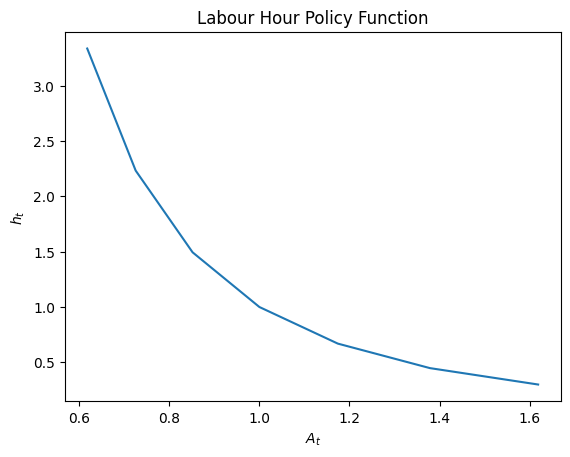

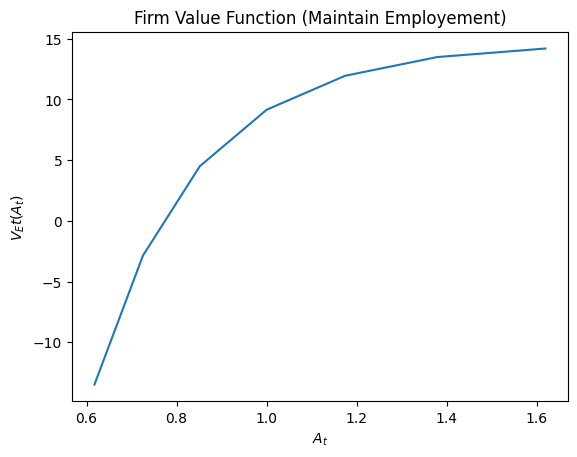

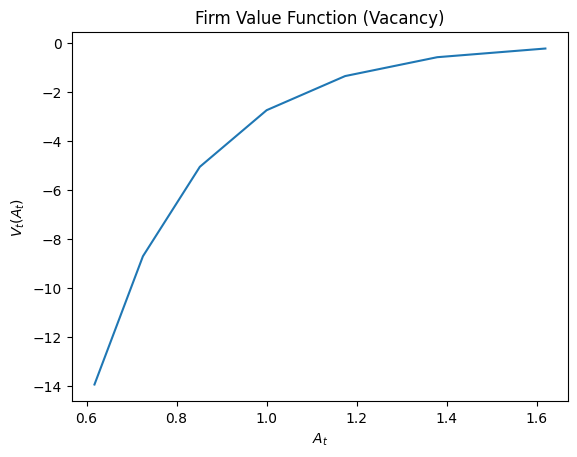

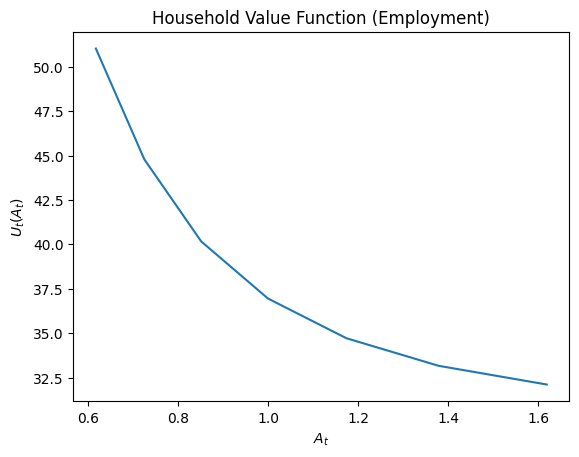

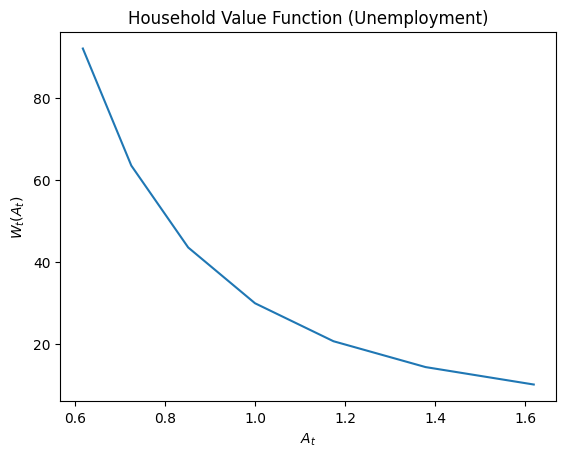

In [ ]:
"""

run_vfi_dgm.py
--------------
This code solves the stochastic growth model using value function iteration.

"""

#%% Import from Python and set project directory
import os

#%% Stochastic Growth Model.
initial_things = labour_model()
initial_things.setup()

# Solve the model.
firms_value(initial_things) # Obtain the policy functions for capital.

# Simulate the model.
# grow_economy(benevolent_dictator) # Simulate forward in time.

# Graphs.
track_growth(initial_things) # Plot policy functions and simulations.